# Phase 2: Decision Tree Classifier

In [1]:
from Preprocessing import *;
from sklearn.model_selection import StratifiedKFold,KFold,train_test_split;
from sklearn.preprocessing import LabelEncoder, OneHotEncoder;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report;
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer;
from pandas.api.types import CategoricalDtype
plt.style.use('ggplot')

In [2]:
data = train_df.reset_index(drop=True)

## Processing test dataset

In [3]:
test = pd.read_json("test.json")
test = test.reset_index(drop=True)

In [4]:
# convert column to datetime
test["created"] = pd.to_datetime(test["created"])
# add hour created column
test["hour_created"] = test["created"].dt.hour

In [5]:
# label encode
test["address"] = test["display_address"].astype('category')
test["address"] = test["address"].cat.codes
test["manager_id"] = test["manager_id"].astype('category')
test["manager"] = test["manager_id"].cat.codes
test.drop(['manager_id'], axis=1, inplace=True)
test["building_id"] = test["building_id"].astype('category')
test["building"] = test["building_id"].cat.codes
test.drop(['building_id'], axis=1, inplace=True)

In [6]:
test.drop(['photos','street_address','features','description','created','display_address'], axis=1, inplace=True)

# 1. Feature Selection

Since the listing_id is unique to each lising, it really isn't relevant for our model and will be removed. We will also remove the photos column because we won't be using this in our model either. We will also remove street_address because we can use the display_address as a categorical value since this is just the general street that the listing is on. This helps identify the general neighbourhood the listing is in for the buyer. The description, created, and features columns are removed because these are represented by newly extracted feature columns from the previous milestone.

In [7]:
data.drop(['photos','listing_id','street_address','features','description','created'], axis=1, inplace=True)

## Binarize data by label encoding

In [8]:
cat_type = CategoricalDtype(categories=["high", "medium", "low"],ordered=True)
cat_type

CategoricalDtype(categories=[u'high', u'medium', u'low'], ordered=True)

In [9]:
# high-0, medium-1, low-2
data["interest_level"] = data["interest_level"].astype(cat_type)
data["target"] = data["interest_level"].cat.codes
data.drop(['interest_level'], axis=1, inplace=True)

In [10]:
data["address"] = data["display_address"].astype('category')
data["address"] = data["address"].cat.codes
data.drop(['display_address'], axis=1, inplace=True)

In [11]:
data["building_id"] = data["building_id"].astype('category')
data["building"] = data["building_id"].cat.codes
data.drop(['building_id'], axis=1, inplace=True)

In [12]:
data["manager_id"] = data["manager_id"].astype('category')
data["manager"] = data["manager_id"].cat.codes
data.drop(['manager_id'], axis=1, inplace=True)

## Split the data

I will split our input and target variables into X and y respectively. We will also split into training and test data so we can see if our models are overfitting the data.

In [13]:
X = data.drop(['target'], axis=1)
y = data['target']
X_tr, X_test, y_tr, y_test = train_test_split(X,y)

In [14]:
X_test.reset_index(inplace=True,drop=True)
X_tr.reset_index(inplace=True,drop=True)

## Fisher score

Since this is only valid for numerica features, we must first take a subset of our data. We will separate the data based on interest level to calculate the mean and standard deviation of each class. These values will be used to calculate the fisher score for each feature. We can then use a filtering technique to find the most relevant features based on the scores. 

In [15]:
# take subset
numeric = ['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building']
num_data = data[['bathrooms','bedrooms','latitude','longitude','price','hour_created','address','manager','building','target']]

In [16]:
# separate data by interest level
high = num_data[num_data['target'] == 2].drop(['target'], axis=1)
med = num_data[num_data['target'] == 1].drop(['target'], axis=1)
low = num_data[num_data['target'] == 0].drop(['target'], axis=1)

In [17]:
# calculate mean of each feature in each class
avg_if = np.array([high.mean(),
      med.mean(),
      low.mean()])
#calculate mean of each feature
avg_f = np.array(num_data.drop(['target'], axis=1).mean())

In [18]:
# calculate variance for each feature
var = np.square(np.array([high.std(),
      med.std(),
      low.std()]))

# calculate probability of each class
prob = np.array([high.shape[0]/float(data.shape[0]),
             med.shape[0]/float(data.shape[0]),
             low.shape[0]/float(data.shape[0])]
)

In [19]:
fisher = []
numerator = []
denomerator = []

for feat in np.arange(0,avg_if.shape[1]):
    for class_i in np.arange(0,avg_if.shape[0]):
        numerator.append(np.array(prob[class_i]*np.square(avg_if[class_i][feat]-avg_f[feat])))
        denomerator.append(np.array(prob[class_i]*var[class_i]))      
    fisher.append(np.array(numerator).sum()/np.array(denomerator).sum())
fisher

[1.4391986856950884e-10,
 1.5495308224893388e-10,
 1.0336764419360136e-10,
 7.75380886324851e-11,
 0.0008348517025325086,
 0.000695716318490876,
 0.0011911021471335808,
 0.0010447074295786081,
 0.0019208781511415576]

In [20]:
top3 = ['building', 'manager', 'address']
top5 = ['building', 'manager', 'address','price', 'hour_created']

From the Fisher scores, it looks like the building, address, and manager have the top 3 fisher scores, in that order.  Price and hour the listing was created also have decent fisher scores. The worst was longitude and the rest weren't that far off either with 10 significant digits. 

# 2. Train Classifiers

## First Version

The classifier doesn't accept the extracted text features from the previous milestone so for the first classifier they were removed and the classifier was trained for the numerical data only. The 3 features with the highest fisher scores are selected for the first classifier. These are building, address, and manager. The default Gini index was used to determine the best split for each node. The classifier predicted with average 62.33% accuracy. You can see the classifier is biased and has higher precision, recall, and f1 scores for the low interest class. More than triple the high interest.

In [21]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
best_acc = 0
for train_index, valid_index in kf.split(X_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[top3]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[top3])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6208672086720867,
 0.6334688346883469,
 0.6313863667163573,
 0.6250169399647649,
 0.6305732484076433]

In [22]:
np.array(acc_scores).mean()

0.6282625196898398

In [23]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.22      0.24      0.23       573
      medium       0.34      0.36      0.35      1635
         low       0.78      0.76      0.77      5171

   micro avg       0.63      0.63      0.63      7379
   macro avg       0.45      0.45      0.45      7379
weighted avg       0.64      0.63      0.64      7379



In [24]:
# Check overfitting
y_pred = clf.predict(X_test[top3])
acc = accuracy_score(y_test, y_pred)
acc

0.6224390243902439

In [25]:
# use best classifier on test dataset
y_pred = best_clf.predict_proba(test[top3])

In [26]:
listing_id = test['listing_id'].values
listing_id = listing_id.reshape(listing_id.shape[0],1)

In [27]:
# Test output for log loss
test_prob = np.concatenate((listing_id,y_pred),axis=1)
np.savetxt('test_v1.csv',test_prob, delimiter=',',header='listing_id,high,medium,low')

## Second Version

Top 5 features according to Fisher scores were used for this classifier. Gini index was used to determine the best split for each node. The classifier predicted with the same average accuracy (62.49%) as the first version.

In [28]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[top5]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[top5])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6235772357723577,
 0.631029810298103,
 0.6347743596693319,
 0.6072638568911777,
 0.6279983737633825]

In [29]:
np.array(acc_scores).mean()

0.6249287272788706

In [30]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.23      0.24      0.24       573
      medium       0.32      0.33      0.32      1635
         low       0.78      0.76      0.77      5171

   micro avg       0.63      0.63      0.63      7379
   macro avg       0.44      0.45      0.44      7379
weighted avg       0.63      0.63      0.63      7379



In [31]:
# Check overfitting
y_pred = clf.predict(X_test[top5])
acc = accuracy_score(y_test, y_pred)
acc

0.625040650406504

## Third Version

All numeric features were used for this classifier. The default Gini index was used to determine the best split for each node like before. The classifier predicted with average 64.72% accuracy. It looks like the classifier has slightly better accuracy with all features.

In [32]:
# perform cross-validation for first set of classifiers
kf = KFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6390243902439025,
 0.6490514905149052,
 0.6509012061254913,
 0.6468356145819216,
 0.6499525680986583]

In [33]:
np.array(acc_scores).mean()

0.6471530539129758

In [34]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.29      0.30      0.29       573
      medium       0.34      0.36      0.35      1635
         low       0.80      0.78      0.79      5171

   micro avg       0.65      0.65      0.65      7379
   macro avg       0.48      0.48      0.48      7379
weighted avg       0.66      0.65      0.65      7379



In [35]:
# Check overfitting
y_pred = clf.predict(X_test[numeric])
acc = accuracy_score(y_test, y_pred)
acc

0.6448780487804878

## Fourth Version

We can check the distribution of the target to see if stratifying the samples will help us identify any under-represented classes.

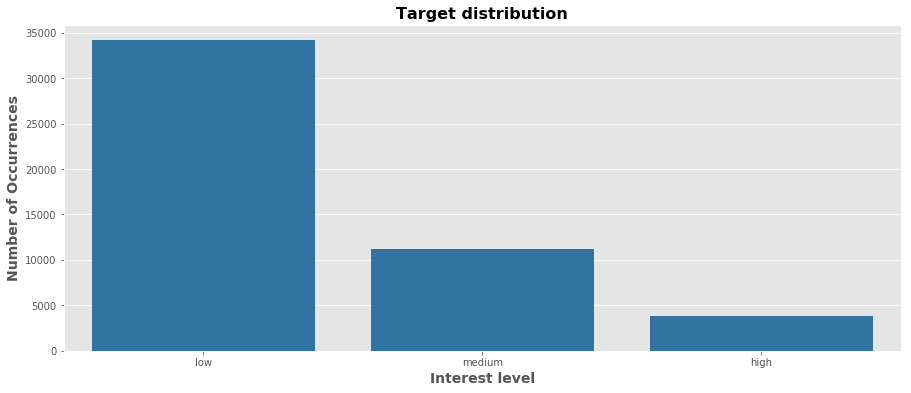

In [36]:
int_level = train_df['interest_level'].value_counts()
plt.figure(figsize=(15,6))
sns.barplot(int_level.index, int_level.values, alpha=1, order=['low','medium','high'],color=color[0])
plt.ylabel('Number of Occurrences', fontsize=14, fontweight='bold')
plt.xlabel('Interest level', fontsize=14, fontweight='bold')
plt.title('Target distribution', fontsize=16, fontweight='bold')
plt.show()

In [37]:
int_all = int_level.sum()
prob_h = int_level[0]/float(int_all)
prob_m = int_level[1]/float(int_all)
prob_l = int_level[2]/float(int_all)
print(prob_h, prob_m, prob_l)

(0.6947578104355957, 0.2276358314531374, 0.07760635811126694)


Since the distribution of our target is skewed, we should stratify our data when spliting so it represents our data well. All numeric features were used for this classifier. Gini index was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.02% accuracy, which is ever so slightly better than regular k-fold cross validation.

In [38]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X_tr, y_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6395663956639567,
 0.6504065040650406,
 0.6535230352303523,
 0.652798482179157,
 0.654513418270534]

In [39]:
np.array(acc_scores).mean()

0.6501615670818081

In [40]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.28      0.30      0.29       571
      medium       0.36      0.36      0.36      1668
         low       0.80      0.79      0.79      5139

   micro avg       0.65      0.65      0.65      7378
   macro avg       0.48      0.48      0.48      7378
weighted avg       0.66      0.65      0.66      7378



In [41]:
# Check overfitting
y_pred = clf.predict(X_test[numeric])
acc = accuracy_score(y_test, y_pred)
acc

0.6455284552845528

## Fifth Version

All numeric features were used for this classifier. Entropy was used to determine the best split for each node. A stratified k-fold cross validation method was used. The classifier predicted with average 65.41% accuracy, which is ever so slightly worse than using gini index to find the best split.

In [42]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
best_acc = 0
for train_index, valid_index in kf.split(X_tr, y_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="entropy", random_state=0)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6490514905149052,
 0.6574525745257452,
 0.6621951219512195,
 0.6548312779509419,
 0.6470588235294118]

In [43]:
np.array(acc_scores).mean()

0.6541178576944447

In [44]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.29      0.31      0.30       571
      medium       0.34      0.35      0.34      1668
         low       0.80      0.78      0.79      5139

   micro avg       0.65      0.65      0.65      7378
   macro avg       0.47      0.48      0.48      7378
weighted avg       0.66      0.65      0.65      7378



In [45]:
# Check overfitting
y_pred = clf.predict(X_test[numeric])
acc = accuracy_score(y_test, y_pred)
acc

0.6452032520325204

## Sixth Version

All numeric features were used for this classifier. Gini index was used to determine the best split for each node since it performed slightly better. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting. The classifier predicted with average 65.49% accuracy.

In [46]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X_tr, y_tr):
    # split data
    X_train, X_valid = X_tr.iloc[train_index], X_tr.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6478319783197832,
 0.6554200542005421,
 0.6570460704607046,
 0.6632335004743191,
 0.6511249661154784]

In [47]:
np.array(acc_scores).mean()

0.6549313139141655

In [48]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.29      0.32      0.30       571
      medium       0.35      0.36      0.35      1668
         low       0.80      0.78      0.79      5139

   micro avg       0.65      0.65      0.65      7378
   macro avg       0.48      0.49      0.48      7378
weighted avg       0.66      0.65      0.65      7378



In [49]:
# Check overfitting
y_pred = clf.predict(X_test[numeric])
acc = accuracy_score(y_test, y_pred)
acc

0.6499186991869919

## Seventh Version

We can introduce our extracted text features for this version.

### Hot encode features vector

The Decision Tree classifier in the sklearn sorts each feature to split the data and doesn't support features that are vectors. So to use any text features we must hot encode them. However, the description vectors are 1119 long so we will only do the features. Looking at the two text features, it seems like description might not be that helpful because there are a lot of irrelevant words/strings in most of them like 'XXX'. 

In [50]:
feat = X_tr['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [51]:
X2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))
X2 = X_tr[numeric].join(X2)

In [52]:
feat = X_test['feat_vect'].apply(lambda x: x.toarray().tolist())
feat_list = []
for i in feat:
    feat_list.append(i)

In [53]:
X_test2 = pd.DataFrame(np.array(feat_list).reshape(np.array(feat_list).shape[0],np.array(feat_list).shape[2]))
X_test = X_test[numeric].join(X_test2)

All numeric features and the hot encoded features were used for this classifier. Gini was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 3 to combat overfitting seen from the previous versions. The classifier predicted with average 53.55% accuracy, which is significantly worse than the previous. Looking at the tfidf vectors of the features column, it looks like each one only has one value out of the 79 word dictionary. The features of most listing must be very similar or have very rare words. The classifier is no longer overfitting but the hot encoded data is throwing off the classifier. It must be splitting the data using these columns closer to the root node, which isn't very helpful.

In [54]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X2, y_tr):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=3)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.6547425474254742,
 0.6592140921409214,
 0.6593495934959349,
 0.654018159642228,
 0.6603415559772297]

In [55]:
np.array(acc_scores).mean()

0.6575331897363575

In [56]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.28      0.29      0.28       571
      medium       0.37      0.37      0.37      1668
         low       0.80      0.80      0.80      5139

   micro avg       0.66      0.66      0.66      7378
   macro avg       0.48      0.48      0.48      7378
weighted avg       0.66      0.66      0.66      7378



In [57]:
# Check overfitting
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.6514634146341464

## Eighth Version

All numeric features and the features were used for this classifier. Gini index seemed to do slightly better so it was used to determine the best split for each node. A stratified k-fold cross validation method was used. Minimum support was changed to 100 and the classifier predicted with average 71.13% accuracy, which is a large improvement. Recall the low interest class was at an all time high with 1.00. The classifier doesn't seem to be predicting the medium or high interest classes corectly at all. There seems to be no overfitting since the performance on the test dataset is only off by less than 1%.

In [58]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, valid_index in kf.split(X2, y_tr):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = DecisionTreeClassifier(criterion="gini", random_state=0,min_samples_leaf=100)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train),check_input=False)
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_clf = clf
acc_scores

[0.7065040650406504,
 0.7149051490514905,
 0.7116531165311654,
 0.7048380539368478,
 0.7186229330441855]

In [59]:
np.array(acc_scores).mean()

0.711304663520868

In [60]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.51      0.17      0.25       571
      medium       0.44      0.26      0.33      1668
         low       0.77      0.93      0.84      5139

   micro avg       0.72      0.72      0.72      7378
   macro avg       0.57      0.45      0.48      7378
weighted avg       0.68      0.72      0.68      7378



In [61]:
# Check overfitting
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.7078048780487805

## Ninth Version

Here we're trying a Random Forest to try and combat inconsistent data creating very different trees. Playing with the parameters, number of folds, and features also gets the same results, on average, as before. Although we do get one classifier that performs the best with an accuracy of 69.92%. This classifier will be used for testing.

In [73]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=10)
acc_scores = []
for train_index, valid_index in kf.split(X2, y_tr):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = RandomForestClassifier(criterion="gini", random_state=0,min_samples_leaf=20,n_estimators=50,min_samples_split=100)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train),np.array(y_train))
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_clf = clf
acc_scores

[0.6998103494987808,
 0.697913844486589,
 0.6987266323489569,
 0.7010840108401084,
 0.6994579945799458,
 0.7001897533206831,
 0.6985632962862565,
 0.700731905665492,
 0.698292220113852,
 0.6968546637744034]

In [68]:
np.array(acc_scores).mean()

0.6991624670915069

In [69]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.67      0.01      0.01       285
      medium       0.30      0.01      0.02       834
         low       0.70      1.00      0.82      2569

   micro avg       0.70      0.70      0.70      3688
   macro avg       0.55      0.34      0.28      3688
weighted avg       0.61      0.70      0.58      3688



In [65]:
# Check overfitting
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.6895121951219512

## Tenth Version

Here we're trying a Random Forest to try and combat inconsistent data creating very different trees. Playing with the parameters, number of folds, and features also gets the same results, on average, as before. Although we do get one classifier that performs the best with an accuracy of 72.55%. This classifier will be used for testing.

In [86]:
# perform cross-validation for first set of classifiers
kf = StratifiedKFold(n_splits=10)
acc_scores = []
for train_index, valid_index in kf.split(X2, y_tr):
    # split data
    X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
    y_train, y_valid = y_tr.iloc[train_index], y_tr.iloc[valid_index]
    # Create classifier object
    clf = RandomForestClassifier(criterion="gini", random_state=0,min_samples_leaf=20,n_estimators=50)
    # Train Decision Tree Classifer
    clf = clf.fit(np.array(X_train[numeric]),np.array(y_train))
    #Predict the response for test dataset
    y_pred = clf.predict(X_valid[numeric])
    acc = accuracy_score(y_valid, y_pred)
    acc_scores.append(acc)
    if acc > best_acc:
        best_clf = clf
acc_scores

[0.7233811975074506,
 0.7206719046328908,
 0.7282579246816581,
 0.7284552845528456,
 0.724390243902439,
 0.7300081322851721,
 0.7199783139062076,
 0.720791542423421,
 0.7343453510436433,
 0.7242407809110629]

In [87]:
np.array(acc_scores).mean()

0.7254520675846791

In [88]:
print(classification_report(y_valid, y_pred, target_names=['high', 'medium','low']))

              precision    recall  f1-score   support

        high       0.47      0.14      0.22       285
      medium       0.48      0.20      0.28       834
         low       0.76      0.96      0.85      2569

   micro avg       0.72      0.72      0.72      3688
   macro avg       0.57      0.43      0.45      3688
weighted avg       0.67      0.72      0.67      3688



In [89]:
# Check overfitting
y_pred = clf.predict(X_test[numeric])
acc = accuracy_score(y_test, y_pred)
acc

0.7169105691056911

# 4. Predictions on  test dataset

Score (multiclass log-loss) = 0.65105 using a Random Forest classifier, the eighth version of classifiers. The benchmark of sample submission is 0.78598 so our classifier isn’t that far off. 

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

In [84]:
# use best classifier on test dataset
y_pred = best_clf.predict_proba(test[numeric])

In [85]:
# Test output for log loss
test_prob = np.concatenate((listing_id,y_pred),axis=1)
np.savetxt('test_best.csv',test_prob, delimiter=',',header='listing_id,high,medium,low')